In [129]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime as dt

# Load data

Use the data from the files for now instead of calling API.

In [199]:
tmdb_movies = pd.read_json("drv_tmdb_movie_details.json")

In [200]:
# tmdb
# max id
print(max(tmdb_movies['id']))

# rows
print(len(tmdb_movies.index))

10010
4865


# Format data

# Movie genre classification

We need to address the following problems before we do movie genre classification:

1. TMDB and IMDB have different movie genre list and this can create issues for prediction. TMDB should have a smaller list than IMDB.
2. We can check if the genre classification are similiar for IMDB and TMDB by the following:
    look at percentage breakdown of each genre. If the results are significantly different amonng the two databases, we will have to explore what causes the difference.
2. A movie can have more than 1 genre. The data from TMDB and IMDB will not indicate which one is the main genre if there is more than 1 genre. However, when we do movie genre prediction, we may only want our reponse to be 1 genre. 
    1. If we do fuzzy classification, we can use see if the results align with multiple genres.
    2. We can also treat it as binary classification problem for each genre, ex. seperate problems of if a movie is Horror and if a movie is Romance. But if the movie number of a genre is too big or too small, the one-vs-all approach may not be good.

Below are useful resources:
* [IMDB genre guide](http://www.imdb.com/help/search?domain=helpdesk_faq&index=2&file=genres)


In [202]:
def get_genre(tmdb_movies ,key):
    tmdb_genre = tmdb_movies[key].tolist()
    tmdb_genre_set = set()
    for g in tmdb_genre:
        tmdb_genre_set = tmdb_genre_set.union(set(g))
    tmdb_genre = list(tmdb_genre_set)
    tmdb_genre.sort()
    return(tmdb_genre)

In [203]:
def is_genre (row, column_name, genre):
    """check if that movie is in this genre as a movie can have more than 1 genre"""
    if genre in row[column_name] :
        return True
    else:
        return False

In [204]:
# as the genre is in list format in the data field, we cannot utilize any data frame function and it is very hard to compare
# thus, we have to transform data set 

def add_genre_columns(tmdb_movies, genre_column):
    tmdb_genre = get_genre(tmdb_movies,genre_column)
    tmdb_movies[u'genre_num'] = tmdb_movies.apply(lambda row: len(row[genre_column]), axis=1)

    for g in tmdb_genre: 
        tmdb_movies[g] = tmdb_movies.apply(lambda row: is_genre(row,genre_column,g), axis=1)



In [205]:
tmdb_genre = get_genre(tmdb_movies,u'genres')
tmdb_movies[u'genre_num'] = tmdb_movies.apply(lambda row: len(row[u'genres']), axis=1)

for g in tmdb_genre: 
    tmdb_movies[g] = tmdb_movies.apply(lambda row: is_genre(row,u'genres',g), axis=1)

In [206]:
np.mean(tmdb_movies[u'genre_num'])

2.255087358684481

In [208]:
tmdb_genre_df = tmdb_movies[tmdb_genre].apply(pd.value_counts).transpose()
tmdb_genre_df

,False,True
Action,3987,878
Adventure,4264,601
Animation,4741,124
Comedy,3284,1581
Crime,4102,763
Documentary,4683,182
Drama,2438,2427
Family,4624,241
Fantasy,4511,354
Foreign,4760,105


In [209]:
imdb_genre = get_genre(imdb_movies,u'genre')
imdb_movies[u'genre_num'] = imdb_movies.apply(lambda row: len(row[u'genre']), axis=1)

for g in imdb_genre: 
    imdb_movies[g] = imdb_movies.apply(lambda row: is_genre(row,u'genre',g), axis=1)

In [210]:
imdb_genre_df = imdb_movies[imdb_genre].apply(pd.value_counts).transpose()
imdb_genre_df

,False,True
Action,56,44
Adventure,56,44
Animation,88,12
Biography,96,4
Comedy,80,20
Crime,80,20
Documentary,96,4
Drama,68,32
Family,96,4
Fantasy,84,16


In [211]:
np.mean(imdb_movies[u'genre_num'])

2.96

## Observations on genre list

1. The genre lists between IMDB and TMDB are very similiar so far. Perhaps it is because we have extracted the same movie.
2. A movie has 3 genres on average.
3. Half of the genres(ex. Documentary and War) have only a few movies. One-vs-all approach may not be good.

# Exploratory Analysis for TMDB

In [212]:
print "Dimension of TMDB dataset:" ,tmdb_movies.shape

Dimension of TMDB dataset: (4865, 46)


In [215]:
tmdb_movies.head(5)

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
10000,False,/Ar87X5wNldG33l3Ka1iMK26I6xZ.jpg,None,0,"[Comedy, Drama]",,10000,tt0109747,es,La estrategia del caracol,...,False,False,False,False,False,False,False,False,False,False
10003,False,/lJnl8xIhplfzUBtlJLsWBwvXVBj.jpg,The Saint Collection,68000000,"[Thriller, Action, Romance, Science Fiction, A...",,10003,tt0120053,en,The Saint,...,False,False,False,False,True,True,False,True,False,False
10005,False,/u7IzK6tISpsSuNkWMowl17gSA4e.jpg,Behind Enemy Lines Collection,0,"[Action, Adventure, Thriller]",http://www.foxhome.com/behindenemylinesiiaxiso...,10005,tt0497329,en,Behind Enemy Lines II: Axis of Evil,...,False,False,False,False,False,False,False,True,False,False
10007,False,/l9fdcaqaQQLE2K8cYwfoIPXi0i7.jpg,See No Evil Collection,8000000,"[Horror, Thriller]",,10007,tt0437179,en,See No Evil,...,False,True,False,False,False,False,False,True,False,False
10009,False,/fAzT4AboZXP2Sj3zE2HcQ7qjMi.jpg,Brother Bear Collection,100000000,"[Adventure, Animation, Family]",http://movies.disney.com/brother-bear,10009,tt0328880,en,Brother Bear,...,False,False,False,False,False,False,False,False,False,False


Replace None with NaN:

In [217]:
tmdb_movies.fillna(value=np.nan, inplace=True)

Check features

In [218]:
tmdb_movies.columns.values

array([u'adult', u'backdrop_path', u'belongs_to_collection', u'budget',
       u'genres', u'homepage', u'id', u'imdb_id', u'original_language',
       u'original_title', u'overview', u'popularity', u'poster_path',
       u'production_companies', u'production_countries', u'release_date',
       u'revenue', u'runtime', u'spoken_languages', u'status', u'tagline',
       u'title', u'video', u'vote_average', u'vote_count', u'genre_num',
       u'Action', u'Adventure', u'Animation', u'Comedy', u'Crime',
       u'Documentary', u'Drama', u'Family', u'Fantasy', u'Foreign',
       u'History', u'Horror', u'Music', u'Mystery', u'Romance',
       u'Science Fiction', u'TV Movie', u'Thriller', u'War', u'Western'], dtype=object)

## 1. Check Missing Value and Duplicate

In [442]:
n_missing=[]
p=[]
for col in tmdb_movies:
    n_missing.append(tmdb_movies[col].isnull().values.sum())
    p.append((tmdb_movies[col].isnull().values.sum())/float(tmdb_movies.shape[0]))
missing=pd.DataFrame({'Features': tmdb_movies.columns.values, 'Missing':n_missing, 'Missing Precentage':p })

In [443]:
df_cat=tmdb_movies[['genres', 'original_language',
       'original_title', 'homepage','overview',
       'production_companies', 'production_countries','spoken_languages','status', 'tagline','title']]

In [444]:
n_missing=[]
p=[]
for col in df_cat:
    count=0
    for i in range(tmdb_movies.shape[0]):
        if len(tmdb_movies.iloc[i][col])==0:
            count+=1      
    n_missing.append(count)
    p.append(count/float(tmdb_movies.shape[0]))
missing1=pd.DataFrame({'Features': df_cat.columns.values, 'Missing':n_missing, 'Missing Precentage':p })
frames=[missing, missing1]
result=pd.concat(frames)
print "Number of missing values"
result[result['Missing']!=0]

Number of missing values


,Features,Missing,Missing Precentage
1,backdrop_path,890,0.182939
2,belongs_to_collection,3940,0.809866
12,poster_path,366,0.075231
15,release_date,7,0.001439
0,genres,50,0.010277
3,homepage,4030,0.828366
4,overview,116,0.023844
5,production_companies,871,0.179034
6,production_countries,51,0.010483
7,spoken_languages,26,0.005344


As shown above, 11 features have missing values. "belongs_to_collection", "homepage" and "tagline" has comparatively high missing rate. Other features all have missing rates below 20%. 
For furture modeling, we may need to consider impute some missing values, or delete some features (with high missing rate) that is not very infomative.

In [280]:
tmdb_movies['title'].describe()

count                4865
unique               4754
top       Finders Keepers
freq                    7
Name: title, dtype: object

In [446]:
tmdb_movies['id'].describe()

count     4865.000000
mean      4712.598150
std       3108.842204
min          2.000000
25%       1955.000000
50%       4484.000000
75%       7351.000000
max      10010.000000
Name: id, dtype: float64

In [287]:
tmdb_movies[tmdb_movies['title']=='Finders Keepers'].iloc[:,2:24]

,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average
5507,NaN,0,"[Comedy, Music, Foreign]",,5507,tt0060413,en,Finders Keepers,No overview found.,0.000518,...,[United Kingdom],1966-12-08,0,94,[English],Released,,Finders Keepers,False,0.0
5508,NaN,0,[Comedy],,5508,tt0087260,en,Finders Keepers,On the run from the police and a female roller...,0.281762,...,[United States of America],1984-05-18,0,96,[English],Released,,Finders Keepers,False,5.5
5510,NaN,0,[Comedy],,5510,tt0043534,en,Finders Keepers,No overview found.,0.000230,...,[United Kingdom],1952-01-01,0,74,[English],Released,,Finders Keepers,False,0.0
5513,NaN,0,"[Action, Comedy]",,5513,tt0846779,en,Finders Keepers,No overview found.,0.000393,...,[United States of America],2005-01-01,0,90,[English],Released,,Finders Keepers,False,0.0
5514,NaN,0,[Comedy],,5514,tt0231588,en,Finders Keepers,No overview found.,0.000144,...,[United States of America],1921-01-01,0,35,[English],Released,,Finders Keepers,False,0.0
5515,NaN,0,"[Comedy, Drama]",,5515,tt0018889,en,Finders Keepers,No overview found.,0.000143,...,[United States of America],1928-02-18,0,60,[English],Released,,Finders Keepers,False,0.0
5517,NaN,0,"[Crime, Drama]",,5517,tt0311132,en,Finders Keepers,"This Vitaphone one-reel short, written by the ...",0.000178,...,[United States of America],1929-12-27,0,20,[English],Released,,Finders Keepers,False,0.0


Although 7 movies has title "Finders Keepers", their are completely different movies, and their imdb_id and id are different. So we'll keep movies that have same titles.

There's no duplicate movie in the dataset in terms of TMDB ID.

# 2. Feature Exploration

In [220]:
numeric=tmdb_movies.select_dtypes(include = ['float64', 'int64'])
numeric.columns.values
numeric.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,genre_num
count,4.865000e+03,4865.000000,4865.000000,4.865000e+03,4865.000000,4865.000000,4865.000000,4865.000000
mean,1.352701e+07,4712.598150,0.728872,4.310044e+07,103.146146,5.305694,266.885509,2.255087
std,2.945895e+07,3108.842204,1.080560,1.146627e+08,31.940519,2.481026,649.184148,1.167723
min,0.000000e+00,2.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,1955.000000,0.024937,0.000000e+00,90.000000,5.000000,3.000000,1.000000
50%,0.000000e+00,4484.000000,0.296467,0.000000e+00,100.000000,6.100000,37.000000,2.000000
75%,1.300000e+07,7351.000000,1.023493,2.682836e+07,115.000000,6.900000,232.000000,3.000000
max,3.800000e+08,10010.000000,13.130939,1.845034e+09,480.000000,10.000000,9653.000000,7.000000


In [221]:
#Delete id and genre_num, which are not original features
numeric=numeric.drop(numeric.columns[[1,7]], axis=1)
print "Number of numerical features:", numeric.shape[1]
numeric.describe()

Number of numerical features: 6


,budget,popularity,revenue,runtime,vote_average,vote_count
count,4.865000e+03,4865.000000,4.865000e+03,4865.000000,4865.000000,4865.000000
mean,1.352701e+07,0.728872,4.310044e+07,103.146146,5.305694,266.885509
std,2.945895e+07,1.080560,1.146627e+08,31.940519,2.481026,649.184148
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,0.024937,0.000000e+00,90.000000,5.000000,3.000000
50%,0.000000e+00,0.296467,0.000000e+00,100.000000,6.100000,37.000000
75%,1.300000e+07,1.023493,2.682836e+07,115.000000,6.900000,232.000000
max,3.800000e+08,13.130939,1.845034e+09,480.000000,10.000000,9653.000000


#### a. Distribution of numeric features

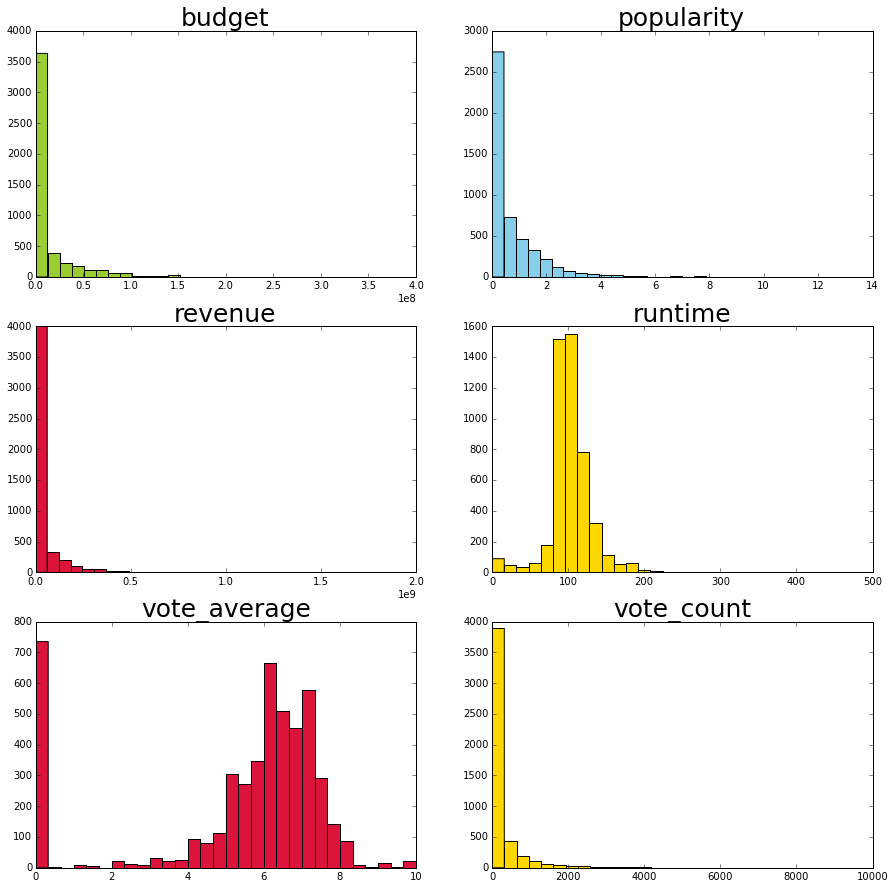

In [222]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15))
ax1.set_title('budget',fontsize=25)
ax1=ax1.hist(numeric['budget'].values,color='yellowgreen',bins=30)
ax2.set_title('popularity',fontsize=25)
ax2=ax2.hist(numeric['popularity'].values,color='skyblue', bins=30)
ax3.set_title('revenue',fontsize=25)
ax3=ax3.hist(numeric['revenue'].values,color='crimson', bins=30)
ax4.set_title('runtime',fontsize=25)
ax4=ax4.hist(numeric['runtime'].values, color='gold',bins=30)
ax5.set_title('vote_average',fontsize=25)
ax5=ax5.hist(numeric['vote_average'].values,color='crimson', bins=30)
ax6.set_title('vote_count',fontsize=25)
ax6=ax6.hist(numeric['vote_count'].values, color='gold',bins=30)
plt.show()

The distribution of budget, revenue, popularity and vote_count are highly right skewed.

The distribution of vote_average and runtime are approximately normal.

Log transformation or other kinds of transformation may need to be considered in future modeling.

#### b. Correlation of numeric features

In [223]:
corr = numeric.corr()

In [224]:
corr

,budget,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.580444,0.724113,0.221215,0.177355,0.575838
popularity,0.580444,1.000000,0.701881,0.241776,0.362759,0.855649
revenue,0.724113,0.701881,1.000000,0.199201,0.192514,0.770402
runtime,0.221215,0.241776,0.199201,1.000000,0.310753,0.208134
vote_average,0.177355,0.362759,0.192514,0.310753,1.000000,0.259351
vote_count,0.575838,0.855649,0.770402,0.208134,0.259351,1.000000


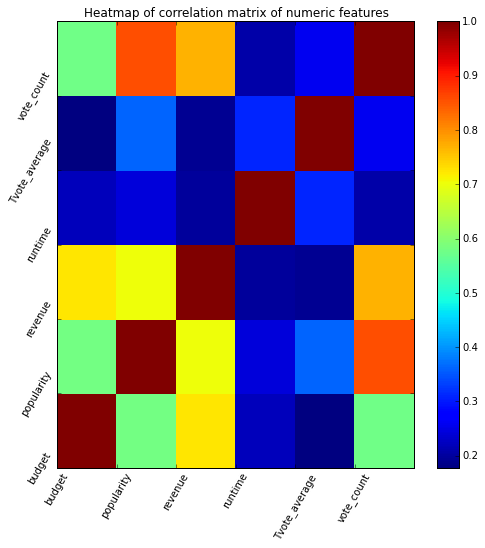

In [225]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(corr)
ax.set_title('Heatmap of correlation matrix of numeric features')
plt.colorbar(ax.pcolor(corr))
ax.set_xticklabels(( 'budget', 'popularity', 'revenue', 'runtime', 'Tvote_average', 'vote_count'),rotation=60)
ax.set_yticklabels(( 'budget', 'popularity', 'revenue', 'runtime', 'Tvote_average', 'vote_count'),rotation=60)
plt.show()

Popularity and vote count are highly correlated. Revenue is also correlated with vote count. We need to pay more attention to these two pairs to avoid collinearity.


#### c. Dummy features

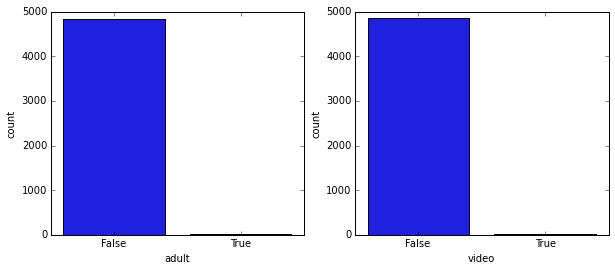

In [488]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x = 'adult', data=tmdb_movies, ax=ax1)
sns.countplot(x = 'video', data=tmdb_movies, ax=ax2)
plt.show()

Most of the movie are not adult type, and no video provided. These two dummy features are not bery informative.

#### d. Categorical Features

In [333]:
categorical = tmdb_movies.select_dtypes(include = ['object'])
categorical.columns.values

array([u'backdrop_path', u'belongs_to_collection', u'genres', u'homepage',
       u'imdb_id', u'original_language', u'original_title', u'overview',
       u'poster_path', u'production_companies', u'production_countries',
       u'release_date', u'spoken_languages', u'status', u'tagline',
       u'title'], dtype=object)

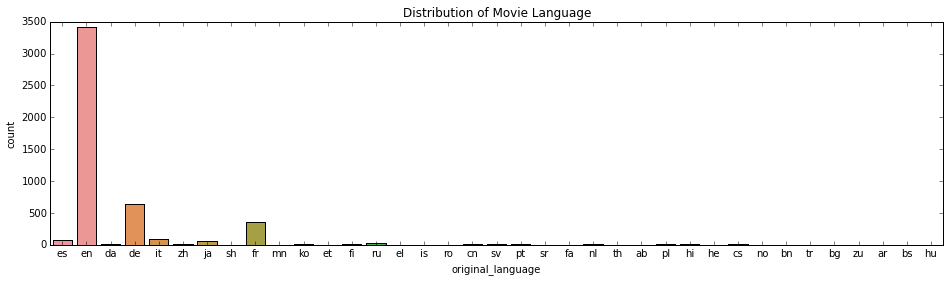

In [487]:
f, ax1 = plt.subplots(1,1, figsize = (16, 4))
sns.countplot(x = 'original_language', data = categorical, ax=ax1)
ax1.set_title("Distribution of Movie Language")
plt.show()

Most movies have **English**(more than 3500) as their original language, while some other movies set **French**, **German**, **Italian** and **Spanish** as their original language.

# 3. Questions that could be answered using TMDB:
1. What is the most common movie genre?
2. How many movie has more than one genre? What is the distribution?
3. What is the most popular movie genre?
4. What is the relationship between movie genre and popularity?
5. Which year had the largest number of movies released?
6. What are the highest rated science fiction movies? 


## 1) What is the most common genre?

In [481]:
tmdb_genre_df.columns.values[1]='Count'

In [482]:
tmdb_genre_df["Relative Frequency"]=tmdb_genre_df["Count"]/float(tmdb_movies.shape[0])

In [483]:
sort=tmdb_genre_df.sort_values(by="Relative Frequency")

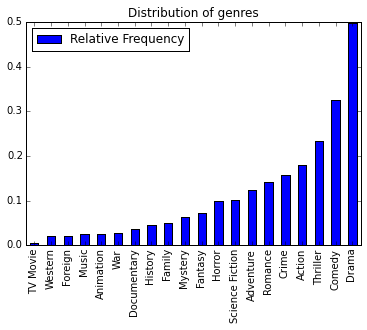

In [484]:
sort[["Relative Frequency"]].plot(kind='bar')
plt.title("Distribution of genres")
plt.show()

The most common movie genre is **Drama**

There are also a quite amont of **Comedy**, **Thriller** and **Action** movies in TMDB.

## 2) Distribution of Multiple Genres

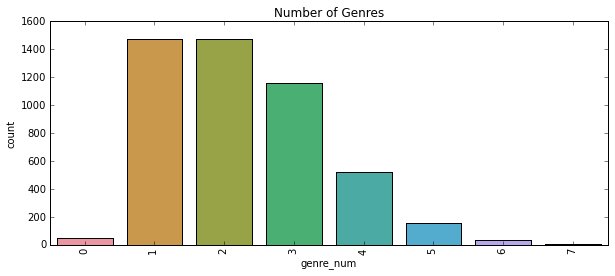

In [486]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax = sns.countplot(x="genre_num", data=tmdb_movies)
xt = plt.xticks(rotation=90)
ax.set_title("Number of Genres")
plt.show()

Most of the movies has 1,2 or 3 genres. Also quite an amount of movies have 4 or more genres.

Let's further investigate movies that have too many genres here:

In [496]:
tmdb_movies[tmdb_movies['genre_num']==7][['title', 'overview', 'genres', 'genre_num', 'popularity']]

,title,overview,genres,genre_num,popularity
2322,Sneakers,When shadowy U.S. intelligence agents blackmai...,"[Adventure, Drama, Action, Comedy, Thriller, C...",7,0.566098
2362,Westworld,"In a futuristic resort, wealthy patrons can vi...","[Action, Adventure, Drama, Horror, Science Fic...",7,1.516945
3098,"The Tulse Luper Suitcases, Part 2: Vaux to the...",The Tulse Luper Suitcases reconstructs the lif...,"[War, Drama, History, Adventure, Comedy, Roman...",7,0.008423
8076,Tuvalu,Set in a dilapidated indoor swimming pool (the...,"[Fantasy, Drama, Comedy, Science Fiction, Roma...",7,0.032928


## 3) What are the most popular movies?

In [189]:
tmdb_movies.sort_values(by=['popularity'], ascending=False).head(5)[['title','popularity', 'genres', 'production_countries', 'release_date']]

,title,popularity,genres,production_countries,release_date
22,Pirates of the Caribbean: The Curse of the Bla...,13.130939,"[Adventure, Fantasy, Action]",[United States of America],2003-07-09
155,The Dark Knight,10.256416,"[Drama, Action, Crime, Thriller]","[United Kingdom, United States of America]",2008-07-16
285,Pirates of the Caribbean: At World's End,9.664116,"[Adventure, Fantasy, Action]",[United States of America],2007-05-19
603,The Matrix,9.466876,"[Action, Science Fiction]","[Australia, United States of America]",1999-03-30
425,Ice Age,9.259527,"[Animation, Comedy, Family, Adventure]",[United States of America],2002-03-10


## 4) What is the relationship between movie genre and popularity?

In [538]:
meanpop=[]
for genre in tmdb_genre:
    meanpop.append(tmdb_movies.groupby(genre)["popularity"].mean()[1])

In [539]:
pop=pd.DataFrame(tmdb_genre)
pop["popularity"]=meanpop
pop=pop.sort_values(by='popularity')
pop.columns.values[0]='genre'

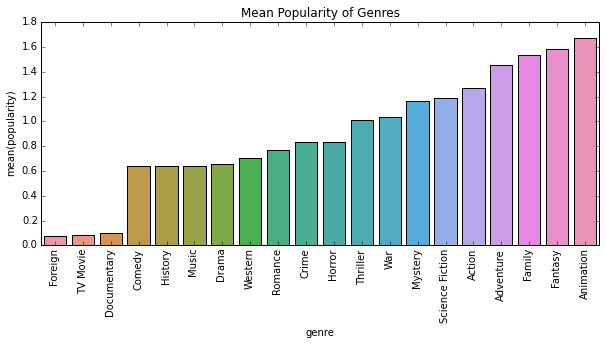

In [554]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax = sns.barplot(x='genre',y="popularity", data=pop)
xt = plt.xticks(rotation=90)
ax.set_title("Mean Popularity of Genres")
plt.show()

## 5) Which year had the most number of movies released?

In [394]:
tmdb_movies['release_date'].describe()

count           4865
unique          3660
top       2007-01-01
freq              19
Name: release_date, dtype: object

In [395]:
tmdb_movies['release_date'] = pd.to_datetime(tmdb_movies['release_date'], errors='coerce')

In [396]:
year = tmdb_movies['release_date'].dt.year

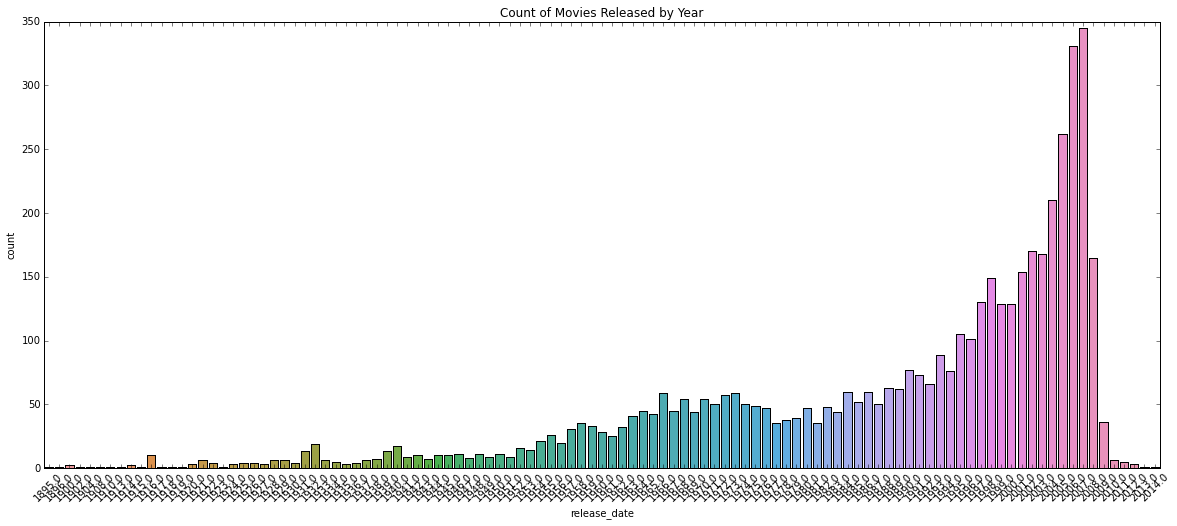

In [397]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
sns.countplot(x = year, ax=ax)
ax.set_title("Count of Movies Released by Year")
xt = plt.xticks(rotation=45)

## 6) What are the highest rated science fiction movies?

In [180]:
sf=tmdb_movies[tmdb_movies['Science Fiction']==True]

In [240]:
top10=sf.sort_values(by=['vote_average'], ascending=False).head(10)

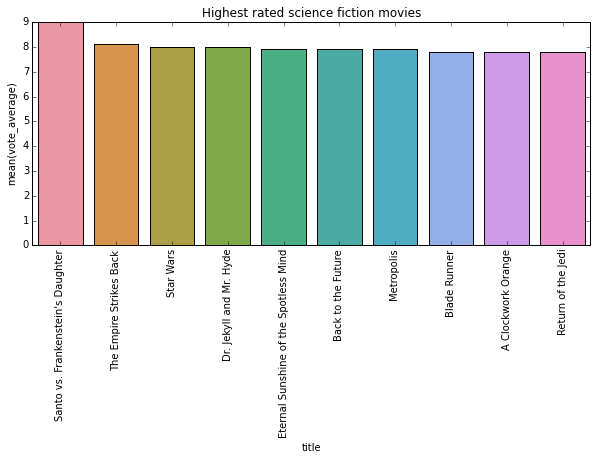

In [247]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax = sns.barplot(x="title", y="vote_average", data=top10)
xt = plt.xticks(rotation=90)
ax.set_title("Highest rated science fiction movies")
plt.show()

In [248]:
top10[['title','overview', 'popularity','production_countries', 'release_date',
       'revenue', 'runtime', 'vote_average']]

,title,overview,popularity,production_countries,release_date,revenue,runtime,vote_average
3205,Santo vs. Frankenstein's Daughter,"Dr. Frankenstein and her assistant, Dr. Yanco,...",0.096475,[Mexico],1971-01-02,0,97,9.0
1891,The Empire Strikes Back,"The epic saga continues as Luke Skywalker, in ...",3.826274,[United States of America],1980-05-17,538400000,124,8.1
11,Star Wars,Princess Leia is captured and held hostage by ...,7.484705,[United States of America],1977-05-25,775398007,121,8.0
3017,Dr. Jekyll and Mr. Hyde,Dr. Henry Jekyll experiments with scientific m...,0.008089,[],1920-04-01,0,40,8.0
38,Eternal Sunshine of the Spotless Mind,"Joel Barish, heartbroken that his girlfriend u...",4.014330,[United States of America],2004-03-19,72258126,108,7.9
105,Back to the Future,Eighties teenager Marty McFly is accidentally ...,6.336256,[United States of America],1985-07-03,381109762,116,7.9
19,Metropolis,In a futuristic city sharply divided between t...,1.321289,[Germany],1927-01-10,650422,153,7.9
78,Blade Runner,In the smog-choked dystopian Los Angeles of 20...,5.286044,"[United States of America, Hong Kong, United K...",1982-06-25,33139618,117,7.8
185,A Clockwork Orange,Demonic gang-leader Alex goes on the spree of ...,2.869388,"[United Kingdom, United States of America]",1971-12-18,26589000,136,7.8
1892,Return of the Jedi,As Rebel leaders map their strategy for an all...,2.818903,[United States of America],1983-05-23,572700000,135,7.8


### Major problems

In [ ]:
lalalala